<a href="https://colab.research.google.com/github/vlad-gby/ds_5_mini-projects/blob/main/01_fin_time-s_analysis/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Financial Time-Series Analysis
Scenario: You are a quantitative analyst given a CSV file with daily stock price data for a tech company.

Your Task: Your objective is to perform a basic financial analysis. You must load the data, calculate the daily price change (return), and then compute the 30-day rolling volatility of those returns. Finally, identify "high volume" trading days, defined as days where the trading volume was more than 1.5 standard deviations above the average volume. The final DataFrame should contain the original data plus new columns for daily_return, 30-day_volatility, and a boolean is_high_volume flag.

So, the CSV provided by Gemini gave us some not interesting results, so i decide to recreate the synthetic data using my own random algorythm.

In [115]:
import numpy as np
import pandas as pd

# url = 'https://raw.githubusercontent.com/vlad-gby/ds_5_mini-projects/main/01_fin_time-s_analysis/stock_data.csv'
# stock_data = pd.read_csv(url)

# # Normalize the column names, convert to daytime type and set as index
# stock_data.columns = stock_data.columns.str.lower().str.replace(' ', '_')
# stock_data['date'] = pd.to_datetime(stock_data['date'])
# stock_data = stock_data.set_index('date')

rng = np.random.default_rng(seed=123)

# Create basic structure with dates and column names
stock_data = pd.DataFrame(columns=['date', 'open', 'high', 'low', 'close', 'volume'])
stock_data['date'] = pd.date_range(start='2024-01-02', periods=10_000, freq='D')

open_price = 150
# Add percentage change for high, low, night_change, volume and close(cumulative)
night_change = rng.standard_normal(10_000)/150 + 1
high_change_perc = np.abs(rng.standard_normal(10_000))/100 + 1
low_change_perc = -np.abs(rng.standard_normal(10_000))/100 + 1
close_change_perc = np.cumprod(rng.standard_normal(10_000)/100 + 1)

# Populate columns with synthetic data
stock_data['open'] = pd.concat([pd.Series([open_price]), pd.Series(open_price * close_change_perc * night_change)], ignore_index=True)
# At this moment I shifted the whole 'open' column, I've probably just forgot about .shift method, which is more readable for developers, and for myself
stock_data['high'] = stock_data['open'] * high_change_perc
stock_data['low'] = stock_data['open'] * low_change_perc
stock_data['close'] = open_price * close_change_perc
stock_data['volume'] = 10_000_000 + (high_change_perc - low_change_perc) * 10_000_000
stock_data.set_index('date', inplace=True)

print(stock_data.head(10))




                  open        high         low       close        volume
date                                                                    
2024-01-02  150.000000  150.707485  148.911535  148.628914  1.011973e+07
2024-01-03  147.648833  150.106034  146.838069  148.117890  1.022133e+07
2024-01-04  147.754718  148.089301  147.738238  148.006489  1.002376e+07
2024-01-05  149.277298  149.315833  148.821065  145.716556  1.003314e+07
2024-01-06  145.904991  145.953143  144.546868  146.965127  1.009638e+07
2024-01-07  147.866739  150.511211  144.318157  146.463489  1.041883e+07
2024-01-08  147.026987  149.128966  146.080602  146.890094  1.020733e+07
2024-01-09  146.266826  148.509722  143.321837  149.429714  1.035469e+07
2024-01-10  149.969606  152.482574  149.696378  149.691193  1.018578e+07
2024-01-11  149.375249  153.305855  148.360491  150.550987  1.033107e+07


Daily return is closing price - previous closing price over the previous closing price (to get the %)

In [116]:
stock_data['daily_return'] = (stock_data['close'] - stock_data['close'].shift(1)) / stock_data['close'].shift(1)
print(stock_data['daily_return'][:10])

date
2024-01-02         NaN
2024-01-03   -0.003438
2024-01-04   -0.000752
2024-01-05   -0.015472
2024-01-06    0.008568
2024-01-07   -0.003413
2024-01-08    0.002913
2024-01-09    0.017289
2024-01-10    0.001750
2024-01-11    0.005744
Name: daily_return, dtype: float64


Calculate the standard deviation of previous 30 days' returns, how volatile the price was. (first 29 entries can't have a value, as they don't have full 30 days that preceed them)

In [117]:
stock_data['30_day_volatility'] = stock_data['daily_return'].rolling(30).std()
stock_data['smoothed_volatility'] = stock_data['30_day_volatility'].rolling(500).mean()
print(stock_data['smoothed_volatility'].tail(10))

date
2051-05-10    0.010097
2051-05-11    0.010099
2051-05-12    0.010100
2051-05-13    0.010100
2051-05-14    0.010100
2051-05-15    0.010100
2051-05-16    0.010102
2051-05-17    0.010103
2051-05-18    0.010104
2051-05-19    0.010105
Name: smoothed_volatility, dtype: float64


Define days with big stock volume

In [118]:
stock_data['is_high_volume'] = (stock_data['volume'] - stock_data['volume'].mean()) > stock_data['volume'].std() * 3.5
print('Volume records for high-volume days: ')
print(stock_data.loc[stock_data['is_high_volume'], 'volume'])
print('Mean volume is: ', stock_data['volume'].mean(), ' And max volume is: ', stock_data['volume'].max())

Volume records for high-volume days: 
date
2024-04-01    1.050160e+07
2025-03-21    1.052431e+07
2026-04-07    1.054860e+07
2027-06-11    1.046164e+07
2028-01-14    1.049131e+07
2028-07-01    1.046520e+07
2029-11-30    1.046786e+07
2030-02-25    1.053037e+07
2030-11-22    1.046255e+07
2031-03-24    1.048655e+07
2033-07-21    1.053171e+07
2035-10-28    1.049238e+07
2036-07-21    1.048010e+07
2037-02-09    1.048131e+07
2040-05-28    1.048920e+07
2041-04-28    1.053660e+07
2042-09-11    1.047544e+07
2043-05-03    1.047803e+07
2044-03-26    1.051305e+07
2044-08-06    1.047352e+07
2047-05-24    1.047923e+07
2049-05-16    1.047283e+07
2049-08-07    1.052117e+07
2049-08-24    1.048205e+07
Name: volume, dtype: float64
Mean volume is:  10159485.305927983  And max volume is:  10548597.223749764


Conclusion: The analysis was successful. The final DataFrame now includes the calculated daily returns, 30-day volatility, and a boolean flag identifying high-volume trading days, providing key metrics for further financial modeling.

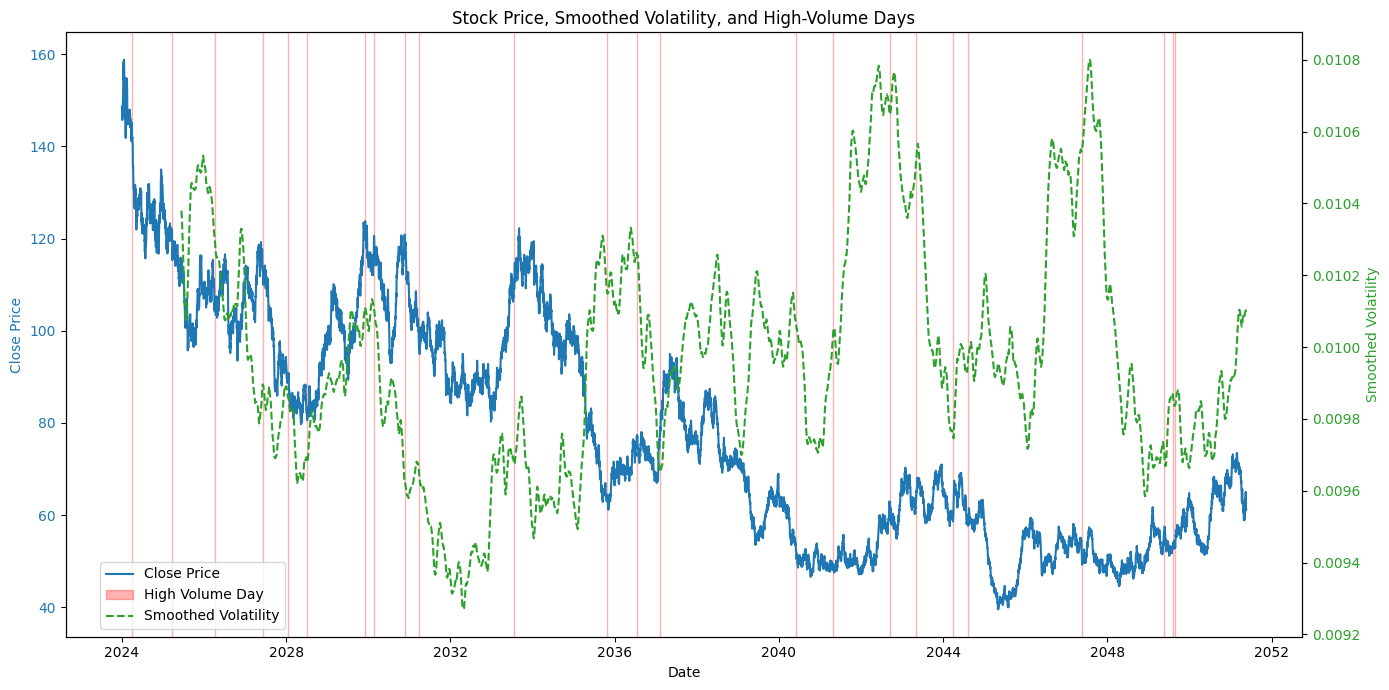

In [119]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the closing price on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(stock_data.index, stock_data['close'], color=color, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot the 30-day volatility
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Smoothed Volatility', color=color)
ax2.plot(stock_data.index, stock_data['smoothed_volatility'], color=color, linestyle='--', label='Smoothed Volatility')
ax2.tick_params(axis='y', labelcolor=color)

# Highlight high-volume days
high_volume_dates = stock_data[stock_data['is_high_volume']].index
for date in high_volume_dates:
    ax1.axvspan(date, date, color='red', alpha=0.3, label='High Volume Day' if date == high_volume_dates[0] else "")

# Add a title and legend
plt.title('Stock Price, Smoothed Volatility, and High-Volume Days')
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.07,0.2))

plt.show()